In [1]:
#Load module

import sys
from pathlib import Path, PurePath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

try:
    base_dir.exists()
except NameError:
    curr_dir = Path().resolve()
    base_dir = curr_dir  

data_dir = base_dir / "data" 

import settings as sett

sys.path.append(str(data_dir.absolute()))

import data_loader as dl 


key = ['h', 'u', 'v']
day0 = sett.day0
day1 = sett.day1
days = [day0, day1]
param_list = sett.param_list

Np = len(param_list)

LOAD

In [2]:
## Load mesh and bathymetry

loaded_mesh = np.load(data_dir / Path('shinnecock_domain.npz'), allow_pickle=True)

mesh = loaded_mesh['mesh'].item()
nodes = mesh['nodes']
elems = mesh['triangles']
time = loaded_mesh['time']
bathy = loaded_mesh['bathy']


print(f'Number of Finite Element nodes = {nodes.shape[0]}')

Number of Finite Element nodes = 3070


In [3]:
## Load state vectors for each parameter

variables = {}

for param in param_list:
    loaded_data = np.load(data_dir / Path(f'shinnecock_{param}.npz'), allow_pickle=True)
    variables[param] = {
        'h': loaded_data['h'],
        'u': loaded_data['u'],
        'v': loaded_data['v']
    }

print(f'Number of parametric simulations loaded = {len(param_list)}')

Number of parametric simulations loaded = 7


VISUALIZE

In [4]:
h_test = variables[param_list[0]][key[0]]
u_test = variables[param_list[0]][key[1]]
v_test = variables[param_list[0]][key[2]]


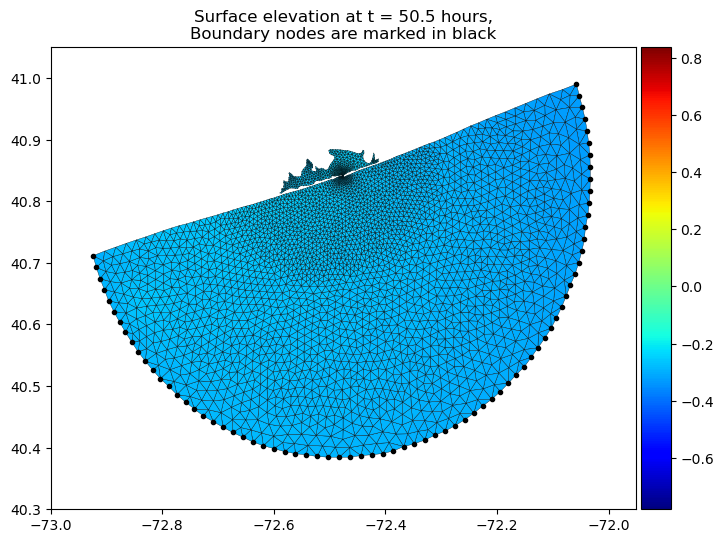

In [21]:
t_index = 100
tn = time[t_index]

field = h_test
valmax = field.max()
valmin = field.min()


fig, axs = plt.subplots(1,1, figsize=(8,6))
im = axs.tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, field[:,t_index],
                      edgecolor='black', cmap = 'jet', vmin = valmin, vmax = valmax, )

## PLOT BOUNDARY NODES
axs.scatter(nodes[:75,0], nodes[:75,1], marker='.', color='black')

axs.set_xlim([-73, -71.95])
axs.set_ylim([40.3,41.05])

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs.set_title(f'Surface elevation at t = {tn/3600} hours,\nBoundary nodes are marked in black')

plt.show()

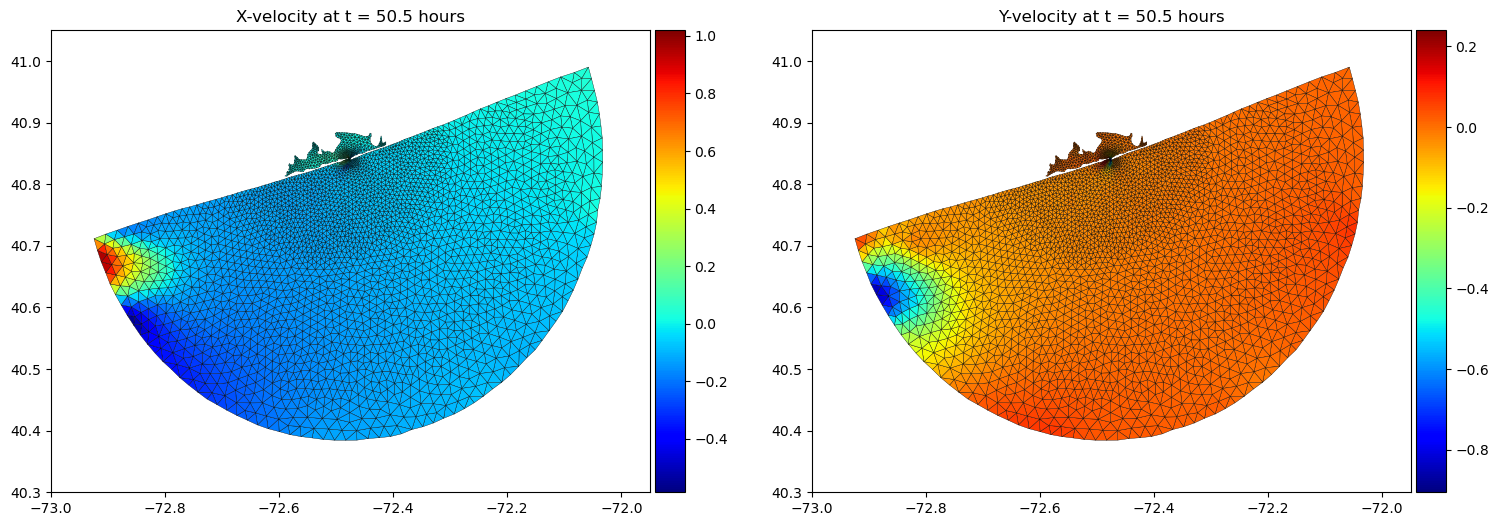

In [15]:



valmax = field.max()
valmin = field.min()

fig, axs = plt.subplots(1,2, figsize=(18,6))
im1 = axs[0].tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, u_test[:,t_index],
                      edgecolor='black', cmap = 'jet', vmin = u_test[:,t_index].min(), vmax = u_test[:,t_index].max(), )
im2 = axs[1].tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, v_test[:,t_index],
                      edgecolor='black', cmap = 'jet', vmin = v_test[:,t_index].min(), vmax = v_test[:,t_index].max(), )

for xs in axs:
    xs.set_xlim([-73, -71.95])
    xs.set_ylim([40.3,41.05])

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

axs[0].set_title(f'X-velocity at t = {tn/3600} hours')
axs[1].set_title(f'Y-velocity at t = {tn/3600} hours')

plt.show()

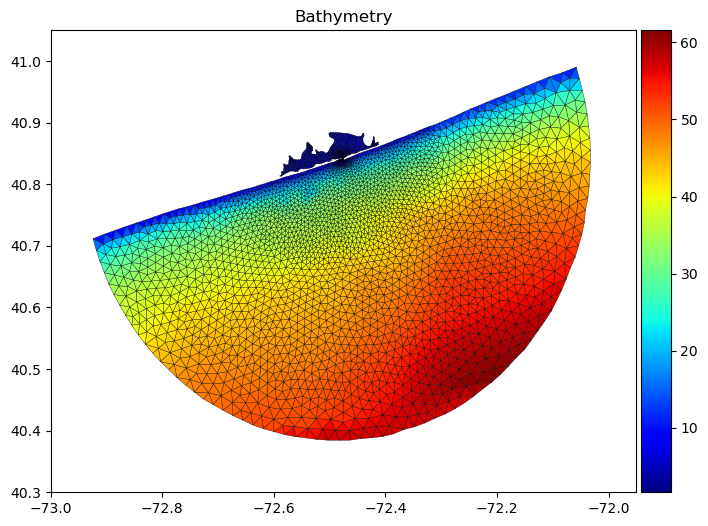

In [17]:
field = bathy
valmax = field.max()
valmin = field.min()

fig, axs = plt.subplots(1,1, figsize=(8,6))
im = axs.tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, field,
                      edgecolor='black', cmap = 'jet', vmin = valmin, vmax = valmax, )

axs.set_xlim([-73, -71.95])
axs.set_ylim([40.3,41.05])

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

axs.set_title(f'Bathymetry')

plt.show()

Three separate DeepONet models are trained to predict water surface elevation, x-velocity and y-velocity. Each DeepONet model uses boundary values of water surface elevation (h[:75,:]) and scalar values of the Manning's n coefficient (n = 0.1, 0.01,...) as input to the branch network. The boundary points of the high-fidelity mesh correspond to the first 75 elements of the node array. 

High-fidelity temporal snapshots are generated by ADCIRC for each Manning's n value in the entire discrete parameter set, 'param_list', at a 30-minute time step over 30 days to produce 1440 snaphots for each parametric instance. The training set is constructed with the temporal snapshots corresponding to the Manning's n value in the `param_train' set and for the time range - [day 10, day 20] i.e. 480 <= t_index <= 960.

Once trained the models are tested against the parameter values in `param_test' and for the time range [day 10, day 30] i.e. 480 <= t_index <= 1440. 